# Application de techniques de *ML* à géolocalisation d'appareils connectés au réseau *Sigfox*

*Farid El Attaoui, Hicham El Ouatiki, Antoine Hue, Vincent Martinez, Thomas Mensch*

Le but de ce challenge est d'estimer les positions géographiques d'appareils connectés au réseau Sigfox.

Ce notebook est organisé de la manière suivante:

 1. Introduction du problème
 2. Analyse exploratoire des données
 3. Construction de la matrice des co-variables
 

## Introduction du problème

Le but de ce challenge est d'estimer les positions géographiques d'appareils connectés au réseau Sigfox.

Les informations disponibles pour ce problème de géolocalisation sont les latitudes et longitudes, et la force du signal (RSSI) des stations de base (BS) qui ont reçu les messages de ces devices.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Modules for basemap and geodetic manipulations
import folium
import utm
from geopy.distance import geodesic

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# Machine learning modules
from sklearn import model_selection, preprocessing

from tensorflow.keras import activations, datasets, layers, losses, metrics, models, backend, regularizers
import tensorflow as tf
#pip install tensorview
import tensorview as tv

import lightgbm

## Exploration des données

### Préparation des données

In [2]:
# Features
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')

# Labels: position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [3]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [4]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [5]:
# determine all Base stations that received at least 1 message
trainBs = np.unique(df_mess_train['bsid'])
testBs = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Nombre de stations pour le jeu de train: {len(listOfBs):d}")
print(f"Nombre de stations pour le jeu de test : {len(testOnlyBs):d}")

Nombre de stations pour le jeu de train: 259
Nombre de stations pour le jeu de test : 8


### Quelques visualisations

#### RSSI en fonction de la distance

In [6]:
df_distance = pd.concat([df_mess_train, pos_train], axis=1)


df_distance['distance_m'] = df_distance.apply(lambda x: geodesic(
    [x['bs_lat'], x['bs_lng']], [x['lat'], x['lng']]).meters, axis=1)

df_distance = df_distance.sort_values(by=['distance_m'])

# near: distance <= 100 km
df_distance_near = df_distance[df_distance['distance_m'] <= 100000]
# far: distance > 100 km
df_distance_far = df_distance[df_distance['distance_m'] > 100000]

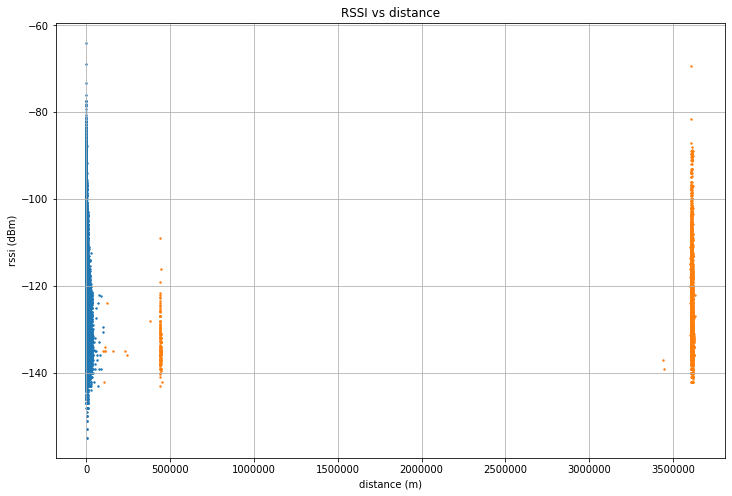

In [7]:
# RSSI vs distance
fig = plt.figure(figsize=(12, 8))

plt.grid()

plt.title('RSSI vs distance')
plt.xlabel('distance (m)')
plt.ylabel('rssi (dBm)')

plt.scatter(df_distance_near['distance_m'], df_distance_near['rssi'], s=2, label='near')
plt.scatter(df_distance_far['distance_m'], df_distance_far['rssi'], s=2, label='far')

plt.show()

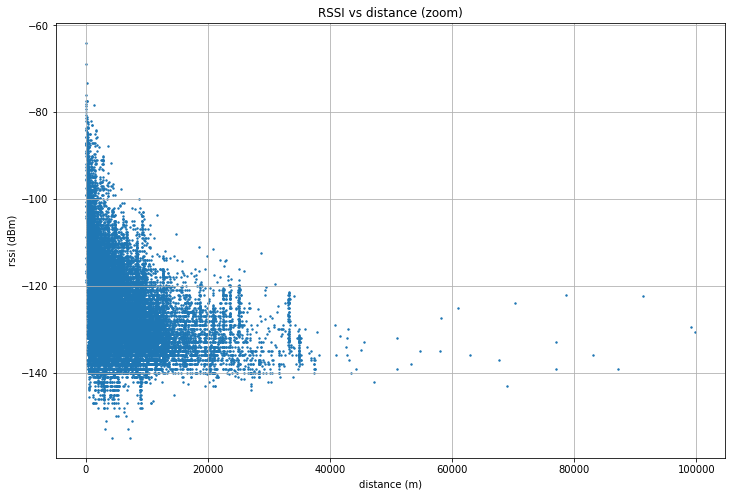

In [8]:
# RSSI vs distance (zoom)
fig = plt.figure(figsize=(12, 8))

plt.grid()

plt.title('RSSI vs distance (zoom)')
plt.xlabel('distance (m)')
plt.ylabel('rssi (dBm)')

plt.scatter(df_distance_near['distance_m'], df_distance_near['rssi'], s=2, label='near')

plt.show()

#### Positions des stations de bases

In [9]:
# determine min/max lat/lon
df_mess_all = pd.concat([df_mess_train, df_mess_test])
df_bsloc_all = df_mess_all.groupby('bsid')[['bs_lat', 'bs_lng']].first()

lon_min = df_bsloc_all['bs_lng'].min()
lon_max = df_bsloc_all['bs_lng'].max()

lat_min = df_bsloc_all['bs_lat'].min()
lat_max = df_bsloc_all['bs_lat'].max()

# train vs. test
df_bsloc_train = df_mess_train.groupby('bsid')[['bs_lat', 'bs_lng']].first()
df_bsloc_test = df_mess_test.groupby('bsid')[['bs_lat', 'bs_lng']].first()

df_bsloc_intersect = df_bsloc_train.merge(df_bsloc_test, how='inner',
                                          on=['bsid','bs_lat', 'bs_lng'] )

df_bsloc_train_only = pd.merge(df_bsloc_train, df_bsloc_test,
                               on=['bsid','bs_lat', 'bs_lng'],
                               how="outer", indicator=True) \
                        .query('_merge=="left_only"') \
                        .drop(columns=['_merge'])

df_bsloc_test_only = pd.merge(df_bsloc_test, df_bsloc_train,
                               on=['bsid','bs_lat', 'bs_lng'],
                               how="outer", indicator=True) \
                        .query('_merge=="left_only"') \
                        .drop(columns=['_merge'])

print(f"all={df_bsloc_all.shape}")
print(f"intersection={df_bsloc_intersect.shape}")
print(f"train_only={df_bsloc_train_only.shape}")
print(f"test_only{df_bsloc_test_only.shape}")

all=(259, 2)
intersection=(160, 2)
train_only=(91, 2)
test_only(8, 2)


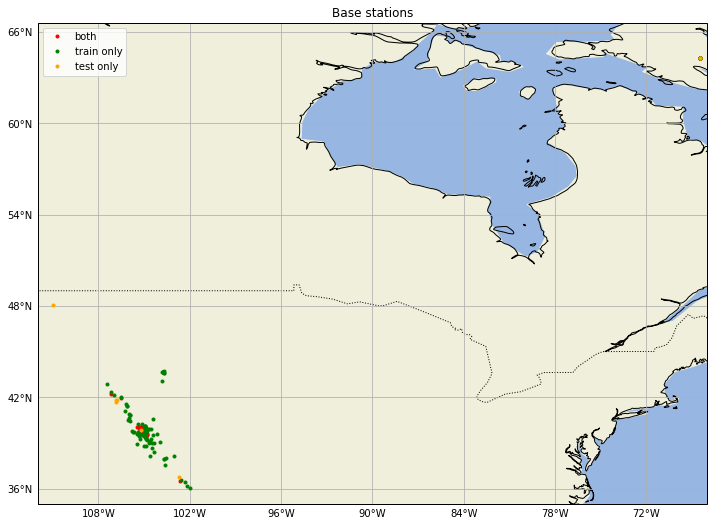

In [10]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

plt.grid()
ax.set_extent([round(lon_min - 1.), round(lon_max + 1.),
               round(lat_min - 1.), round(lat_max + 1.),])

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'])
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.coastlines(resolution='50m')

# plot BS
ax.plot(df_bsloc_intersect['bs_lng'], df_bsloc_intersect['bs_lat'],
        '.', color='red', label='both')
ax.plot(df_bsloc_train_only['bs_lng'], df_bsloc_train_only['bs_lat'],
        '.', color='green', label='train only')
ax.plot(df_bsloc_test_only['bs_lng'], df_bsloc_test_only['bs_lat'],
        '.', color='orange', label='test only')

ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title("Base stations")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.legend()
plt.show()

## Passage en UTM

In [11]:
# functions for conversion
def latlon_to_xy(lat, lon):
    """Conversion lat/lon en UTM"""
    x, y, utm_zone, utm_letter = utm.from_latlon(lat, lon)
    return x, y, utm_zone, utm_letter


def xy_to_latlon(x, y, utm_zone, utm_letter):
    """Conversion UTM en lat/lon"""
    lat, lon = utm.to_latlon(x, y, utm_zone, utm_letter)
    return lat, lon

# Add UTM coordinates columns (x, y, zone, letter)
pos_train[['x', 'y', 'utm_zone', 'utm_letter']] = pos_train.apply(lambda row: pd.Series(latlon_to_xy(row['lat'], row['lng'])),axis=1)
df_mess_train[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_train.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)
df_mess_test[['bs_x', 'bs_y', 'bs_utm_zone', 'bs_utm_letter']] = df_mess_test.apply(lambda row: pd.Series(latlon_to_xy(row['bs_lat'], row['bs_lng'])),axis=1)

## Traitement des messages anormaux (outliers)

In [12]:
print(f"Nombres de messages du jeu d'apprentissage : {len(df_mess_train.messid.unique())}");
print(f"Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : {len(df_mess_train[df_mess_train.bs_lat<60].messid.unique())}");

Nombres de messages du jeu d'apprentissage : 6068
Nombres de messages du jeu d'apprentissage sans les stations au dessus du 60eme parallèle : 5918


In [13]:
print(f"Nombres de messages du jeu de test : {len(df_mess_test.messid.unique())}");
print(f"Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : {len(df_mess_test[df_mess_test.bs_lat<60].messid.unique())}");

Nombres de messages du jeu de test : 5294
Nombres de messages du jeu de test sans les stations au dessus du 60eme parallèle : 5199


### Analyse

Il y a 150 messages du jeu d'apprentissage et 95 messages du jeu de test qui refèrent uniquement aux stations situées au dessus du 60eme parallèle (dans la zone UTM 19).
Ces stations sont très éloignées des autres données et semblent donc être des anomalies.

En analysant les coordonnées des labels correspondants à ces messages, ils s'avèrent que les appareils sont tous situés dans la zone des autres stations.

Nous prenons donc le parti de modifier les coordonnées de ces stations au barycentre des différentes positions des devices qui ont communiqué uniquement avec ces stations.

In [14]:
mask = ~df_mess_train[df_mess_train.bs_lat > 60.0]['messid'] \
    .isin(df_mess_train[df_mess_train.bs_lat < 60.0]['messid'])

messid_far = df_mess_train[df_mess_train.bs_lat > 60.0]['messid'][mask].unique()

df_contat = pd.concat([df_mess_train, pos_train], axis=1)
zone_19_stations = df_contat[df_contat['messid'].isin(messid_far)]
zone_19_coords = zone_19_stations.mean(axis=0)[['lat', 'lng', 'x', 'y', 'utm_zone']]

# process train messages
mask_19 = df_mess_train['bs_utm_zone'] != 19

df_mess_train.bs_lat = df_mess_train.bs_lat.where(mask_19,
                                                  other=zone_19_coords.lat)
df_mess_train.bs_lng = df_mess_train.bs_lng.where(mask_19,
                                                  other=zone_19_coords.lng)

df_mess_train.bs_x = df_mess_train.bs_x.where(mask_19,
                                              other=zone_19_coords.x)
df_mess_train.bs_y = df_mess_train.bs_y.where(mask_19,
                                              other=zone_19_coords.y)

df_mess_train.bs_utm_zone = df_mess_train.bs_utm_zone.where(mask_19,
                                                            other=zone_19_coords.utm_zone)
df_mess_train.bs_utm_letter = df_mess_train.bs_utm_letter.where(mask_19,
                                                                other="S")

In [15]:
# process test messages
mask_19 = df_mess_test['bs_utm_zone'] != 19

df_mess_test.bs_lat = df_mess_test.bs_lat.where(mask_19,
                                                other=zone_19_coords.lat)
df_mess_test.bs_lng = df_mess_test.bs_lng.where(mask_19,
                                                other=zone_19_coords.lng)

df_mess_test.bs_x = df_mess_test.bs_x.where(mask_19, other=zone_19_coords.x)
df_mess_test.bs_y = df_mess_test.bs_y.where(mask_19, other=zone_19_coords.y)

df_mess_test.bs_utm_zone = df_mess_test.bs_utm_zone.where(mask_19,
                                                          other=zone_19_coords.utm_zone)
df_mess_test.bs_utm_letter = df_mess_test.bs_utm_letter.where(mask_19,
                                                              other="S")

In [16]:
df_mess_train.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,503869.635594,4.385338e+06,13,S
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,504054.699417,4.391937e+06,13,S
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,499242.327010,4.384777e+06,13,S
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,493710.997974,4.405337e+06,13,S
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,503752.467865,4.397031e+06,13,S
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651,502257.923837,4.398018e+06,13,S
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392,498594.756068,4.395004e+06,13,S
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827,499242.327010,4.384777e+06,13,S
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685,496252.321609,4.389432e+06,13,S
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109,495433.468821,4.371736e+06,13,S


## Construction de la matrice des co-variables (*features*)

Pour cette matrice, sont utilisées les 5 meilleures stations de base (BS) qui ont reçu le message. 

Les coordonnées sont calculées en relatif par rapport au barycentre de ces BS en utilisant la moyenne géométrique.

In [17]:
def feat_mat_const(df, listOfBs, keepMax=5):
    """ Feature Matrix construction """
    
    aggCols = ['did', 'pivot_lat', 'pivot_lng', 'pivot_utm_zone'] #'pivot_utm_letter'
    for i in range(keepMax):
        bsCols =[f"bs{i:d}_deltalat",
                 f"bs{i:d}_deltalng", 
                 f"bs{i:d}_rssi"] #, 'bs%d_nseq' % i 'bs%d_active' % i, 
        aggCols = aggCols + bsCols
        
    def aggregateBaseStations(groupBy):
        """ From a RSSI sorted DataFrameGroupBy
            create a dataframe with the 3 best BS 
        """
        
        did = groupBy['did'][0]
        utm_zone = groupBy['bs_utm_zone'][0]
        utm_letter = groupBy['bs_utm_letter'][0]
        bsSet = groupBy.iloc[:keepMax]
            
        # Barycentre par moyenne geometrique
        w_geom = np.exp(bsSet['rssi']) / np.sum(np.exp(bsSet['rssi']))
        
        x_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_x'])) / np.sum(w_geom))
        y_geom = np.exp(np.sum(w_geom * np.log(bsSet['bs_y'])) / np.sum(w_geom))
        
        # Barycentre par moyenne arithmétique
        w_arm = bsSet['rssi'] / np.sum(bsSet['rssi'])
        
        x_arm = np.average(bsSet['bs_x'], weights=w_arm)
        y_arm = np.average(bsSet['bs_y'], weights=w_arm)
        
        bss = []
        for i in range(keepMax):
            if len(bsSet) > i:
                b = bsSet.iloc[i]
                dx = b['bs_x'] - x_geom
                dy = b['bs_y'] - y_geom
                bss.append([dy, dx, b['rssi']])
            else:
                bss.append([0, 0, -1e3])
        df_out = pd.DataFrame(np.concatenate([[did, y_geom, x_geom, utm_zone], np.array(bss).ravel()]).reshape(1, -1), 
                            columns=aggCols)
        # Do not concatenate with Numpy otherwise everything is converted to string
        df_out['pivot_utm_letter'] = utm_letter
        
        return df_out
            
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid') \
           .apply(lambda x: x.sort_values(['rssi'], ascending=False)) \
           .reset_index(drop=True).groupby('messid') \
           .apply(aggregateBaseStations)
    
    return df


# build the matrix
df_feat = feat_mat_const(df_mess_train, listOfBs, 5)

# Faut il garder cette ligne?
df_feat_red = df_feat.drop(['did', 'pivot_utm_zone', 'pivot_utm_letter'], axis=1)

print(df_feat.shape)
df_feat.head()

(6068, 20)


,,did,pivot_lat,pivot_lng,pivot_utm_zone,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi,pivot_utm_letter
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,473335.0,4.385532e+06,503875.059261,13.0,-1.932865e+02,-5.423667e+00,-121.500000,6405.584046,179.640156,-125.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573bf3533e952e19126b256a,0,473335.0,4.384777e+06,499242.327010,13.0,3.725290e-09,-2.328306e-10,-134.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c0cd0f0fe6e735a699b93,0,473953.0,4.398018e+06,502257.923840,13.0,2.033077e-06,-3.075635e-06,-100.000000,-986.550840,1494.544025,-120.000000,7318.848418,-8546.925867,-132.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c1272f0fe6e735a6cb8bd,0,476512.0,4.392668e+06,497617.210698,13.0,2.335382e+03,9.775454e+02,-123.333333,-3235.797476,-1364.889089,-123.666667,-7891.007033,1625.116312,-129.666667,-20932.262557,-2183.741877,-133.000000,0.000000,0.000000,-1000.0,S
573c8ea8864fce1a9a5fbf7a,0,476286.0,4.400569e+06,496289.728728,13.0,-2.606393e-01,-2.428322e-01,-98.000000,733.222531,1504.382903,-106.666667,2934.604628,219.650015,-108.000000,41.528627,-1121.676250,-108.666667,1874.057762,2903.862033,-114.0,S


In [18]:
def ground_truth_const(df_mess_train, pos_train):
    """
    Ground truth construction
    """
    
    df = pd.concat([df_mess_train[['messid']], pos_train], axis=1)
    df_mean   = df.groupby('messid').mean()
    df_letter = df.groupby('messid') \
                  .head(1)[['messid', 'utm_letter']] \
                  .set_index('messid')
    
    return pd.concat([df_mean[['x', 'y', 'utm_zone']], df_letter], axis=1)


ground_truth = ground_truth_const(df_mess_train, pos_train)

ground_truth.head()

,x,y,utm_zone,utm_letter
messid,,,,
573bf1d9864fce1a9af8c5c9,503563.532188,4.384106e+06,13,S
573bf3533e952e19126b256a,503556.428875,4.387552e+06,13,S
573c0cd0f0fe6e735a699b93,502661.655787,4.397837e+06,13,S
573c1272f0fe6e735a6cb8bd,499400.220948,4.393695e+06,13,S
573c8ea8864fce1a9a5fbf7a,495629.964268,4.400918e+06,13,S


## Routines d'évaluation

In [19]:
def vincenty_vec(vec_coord):
    """
    Now using geodesic distance instead of Vincenty
    """
    
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(v[0:2], v[2:]).meters for v in vec_coord]

    return vin_vec_dist

In [20]:
def eval_geoloc(y_train_lat, y_train_lng, y_pred_lat, y_pred_lng):
    """
    Evaluate distance error for each predicted point
    """

    vec_coord = np.array([y_train_lat, y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))

    return err_vec

In [21]:
def plotError(err_vec):
    """
    Plot error cumulative distribution and the 80 quantile
    """

    err80 = np.percentile(err_vec, 80)

    print(f"error @ 80% = {err80:.1f} m")

    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values)

    plt.figure()
    plt.grid()

    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values)) * 100.0,
             label="Opt LLR", c='blue')

    # plot error @ 80%
    plt.axvline(x=err80/1000., ymin=0, ymax=100,
                linestyle='dashed', color='red')

    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)')
    plt.axis([0, 30, 0, 100])

    plt.title('Error Cumulative Probability')

    plt.legend()

# Modèles basé sur des réseaux de neurones (DNN)

In [22]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df_feat_red.values,
                                                                ground_truth[['y', 'x']],
                                                                test_size=0.1)

# Normalize data to get proper network optimization
scaleX = preprocessing.StandardScaler()
scaleX.fit(xtrain)

xtrain = scaleX.transform(xtrain)
xtest = scaleX.transform(xtest)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ytrain)

ytrain = scaleY.transform(ytrain)

In [23]:
model1 = models.Sequential([
    layers.Dense(128, name='dense_1', activation=activations.relu,
                 input_shape=[df_feat_red.shape[1]]),
    layers.Dropout(0.01),
    layers.Dense(32, name='dense_2', activation=activations.relu),
   #  layers.Dropout(0.01),
    layers.Dense(2, name='dense_3', activation=activations.linear),
])

model1.compile(optimizer='adam',
          loss=losses.MeanSquaredError())
    
model1.summary()

metricNames = ['Loss']

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
_________________________________________________________________


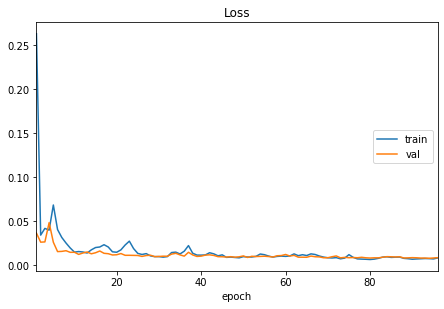

In [24]:
nEpochs = 96
batchSize = 64

tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                     cell_size=(6,4),
                                     columns=2,
                                     iter_num=nEpochs, wait_num=1)

history1 = model1.fit(xtrain, ytrain,
                      epochs=nEpochs,
                      batch_size=batchSize, 
                      validation_split=0.1, 
                      verbose=0,
                      callbacks=[tvPlot]);

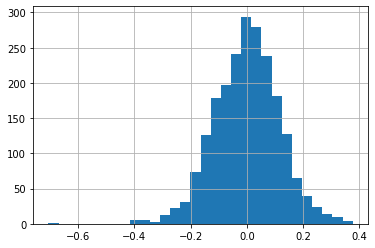

In [25]:
weights1 = model1.get_weights()

fig = plt.figure()

plt.grid()
plt.hist(weights1[0].ravel(), bins=30);

### Evaluation du DNN

In [26]:
yEst = model1.predict(xtest)
yEst = scaleY.inverse_transform(yEst)

error @ 80% = 3971.0 m


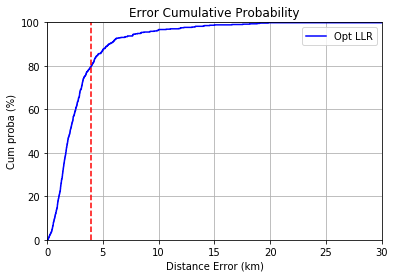

In [27]:
# The coordinates are in true X,Y for distance computation (UTM => directly in meters)
#delta_y = yEst[:, 0] - ytest[:, 0]
#delta_x = yEst[:, 1] - ytest[:, 1]

delta_y = yEst[:, 0] - ytest.values[:,0]
delta_x = yEst[:, 1] - ytest.values[:,1]

dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)

plotError(dnnErr_vec)

## DNN avec validation "leave out device K fold"

Utilisation de GroupKFold de Scikit Learn, génère K fold en évitant que les éléments d'un groupe se trouvent dans le train et le valid. K=24 est choisit pour avoir une distribution des performances (voir histogramme ci-dessous).

In [28]:
gkl1o = model_selection.GroupKFold(24) #model_selection.LeaveOneGroupOut()

In [29]:
scaleX = preprocessing.StandardScaler()
scaleX.fit(df_feat_red)
df_feat_scaled = scaleX.transform(df_feat_red)

scaleY = preprocessing.StandardScaler()
scaleY.fit(ground_truth[['y', 'x']])
yscaled = scaleY.transform(ground_truth[['y', 'x']])

In [30]:
nEpochs = 96

errors80Dnn = []
i = 0
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    
    i+=1
    if i % 4 == 0:
        print('Split #', i)  
    
    xtrain = df_feat_scaled[train]
    xval = df_feat_scaled[val]
    ytrain = yscaled[train]
    yval = yscaled[val]
    
    model1.reset_states()
    model1.fit(xtrain, ytrain,
               epochs=nEpochs,
               batch_size=batchSize, 
               validation_data=(xval, yval),
               verbose=0)
    
    # Evaluate
    yEst = model1.predict(xval)
    yEst = scaleY.inverse_transform(yEst)
    
    delta_y = yEst[:,0] - ground_truth['y'][val]
    delta_x = yEst[:,1] - ground_truth['x'][val]
    
    # Estimates are in delta of UTM coordinates => meters
    dnnErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    err80 = np.percentile(dnnErr_vec, 80)
    #print('Err @ 80%%, %.1fm' % (err80))
    errors80Dnn.append(err80) 

Split # 4
Split # 8
Split # 12
Split # 16
Split # 20
Split # 24


# Modèle de gradient boosting ( LightGBM) 

## Grid Search avec "Leave out device K fold" pour récupérer les meilleures paramètres pour LGBM

In [31]:
# group_kfold = model_selection.GroupKFold(8) #model_selection.LeaveOneGroupOut()

# from sklearn.model_selection import GridSearchCV

# gridParams = {
#     'learning_rate': [0.01,0.02,0.03],
#     'n_estimators': [750,1000,1250,1500],
#     'num_leaves': [25,30,35], 
#     'feature_fraction': [0.9],
#     'bagging_fraction': [0.85],
#     'bagging_freq': [3],
#     'reg_lambda' : [1.,1.25,1.5],
# }

# # Create classifier to use. Note that parameters have to be input manually
# # not as a dict!
# lgbm_lat = lightgbm.LGBMRegressor(boosting_type='gbdt',
#                                   objective='regression',
#                                   n_jobs=-1,  # Updated from 'nthread'
#                                   silent=True)

In [32]:
# best_params_lat=[]
# best_scores_lat=[]

# for grid in grid_table_lat:
#     best_params_lat.append(grid.best_params_)
#     best_scores_lat.append(grid.best_score_)
    
# print(max(best_scores_lat))
# print(best_scores_lat.index(max(best_scores_lat)))
# best_params_lat[best_scores_lat.index(max(best_scores_lat))]

## LGBM avec validation "Leave out device K fold"

In [33]:
df_feat.head()

,,did,pivot_lat,pivot_lng,pivot_utm_zone,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi,pivot_utm_letter
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,473335.0,4.385532e+06,503875.059261,13.0,-1.932865e+02,-5.423667e+00,-121.500000,6405.584046,179.640156,-125.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573bf3533e952e19126b256a,0,473335.0,4.384777e+06,499242.327010,13.0,3.725290e-09,-2.328306e-10,-134.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c0cd0f0fe6e735a699b93,0,473953.0,4.398018e+06,502257.923840,13.0,2.033077e-06,-3.075635e-06,-100.000000,-986.550840,1494.544025,-120.000000,7318.848418,-8546.925867,-132.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0,S
573c1272f0fe6e735a6cb8bd,0,476512.0,4.392668e+06,497617.210698,13.0,2.335382e+03,9.775454e+02,-123.333333,-3235.797476,-1364.889089,-123.666667,-7891.007033,1625.116312,-129.666667,-20932.262557,-2183.741877,-133.000000,0.000000,0.000000,-1000.0,S
573c8ea8864fce1a9a5fbf7a,0,476286.0,4.400569e+06,496289.728728,13.0,-2.606393e-01,-2.428322e-01,-98.000000,733.222531,1504.382903,-106.666667,2934.604628,219.650015,-108.000000,41.528627,-1121.676250,-108.666667,1874.057762,2903.862033,-114.0,S


In [34]:
params={
    'boosting_type': 'gbdt',#Ces parametres fournissent un meilleur résultat que ceux qu'a fourni la grid search ci dessus
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'bagging_fraction': 0.85,
    'bagging_freq': 3,
    'feature_fraction': 0.9,
    'learning_rate': 0.01,
    'n_estimators': 1250,
    'num_leaves': 20,
    'reg_lambda': 1.25}

# params={
#     'boosting_type': 'gbdt',#gbdt"4563m
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'bagging_fraction': 0.85,
#     'bagging_freq': 3,
#     'feature_fraction': 0.9,
#     'learning_rate': 0.03,
#     'n_estimators': 1500,
#     'num_leaves': 35,
#     'reg_lambda': 1.25}

errors80Lgbm = []
lgbmModels = []
i = 0
for train, val in gkl1o.split(df_feat, groups=df_feat['did']):
    i+=1
    if i % 4 == 0:
        print('Split #', i)
    
    xtrain = df_feat_red.values[train]
    xval = df_feat_red.values[val]
    
    lat_train = lightgbm.Dataset(xtrain, ground_truth['y'][train])
    lat_valid = lightgbm.Dataset(xval, ground_truth['y'][val])
    model_lat = lightgbm.train(params,
                           lat_train,
                           valid_sets=lat_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    lng_train = lightgbm.Dataset(xtrain, ground_truth['x'][train])
    lng_valid = lightgbm.Dataset(xval, ground_truth['x'][val])
    model_lng = lightgbm.train(params,
                           lng_train,
                           valid_sets=lng_valid,
                           num_boost_round=5000,
                           early_stopping_rounds=250,verbose_eval=False) 

    # Evaluate
    lat_pred = model_lat.predict(xval)
    lng_pred = model_lng.predict(xval)
    
    delta_y = lat_pred - ground_truth['y'][val]
    delta_x = lng_pred - ground_truth['x'][val]
    
    # Estimates are in delta of UTM coordinates => meters
    lgbmErr_vec = np.sqrt(delta_x**2 + delta_y**2)
    err80 = np.percentile(lgbmErr_vec, 80)
    errors80Lgbm.append(err80) 
    lgbmModels.append([model_lat, model_lng])

C:\Users\MS_BGD\Anaconda3\envs\tf2-gpu\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Split # 4
Split # 8
Split # 12
Split # 16
Split # 20
Split # 24


In [35]:
def lgbmPredict(models, X, degreeOutput):
    
    X_red = X.drop(['did', 'pivot_utm_zone',  'pivot_utm_letter'], axis=1)
    
    lat, lng = np.zeros(len(X_red)), np.zeros(len(X_red))
    for m in models:
        lat += m[0].predict(X_red)
        lng += m[1].predict(X_red)
    
    lat = lat / len(models)
    lng = lng / len(models)
    
    if degreeOutput:
        lat_out, lng_out = np.empty(len(lat)), np.empty(len(lng))
        for i, (y, x, uz, ul) in enumerate(zip(lat, lng, X['pivot_utm_zone'], X['pivot_utm_letter'])):
            a, b = xy_to_latlon(x, y, uz, ul)
            lat_out[i] = a
            lng_out[i] = b
        return lat_out, lng_out
    else:
        return lat, lng

## Graphique comparatif des modèles

Mean error over device folds @ 80%, DNN : 4381.9m, LGBM : 4563.8m


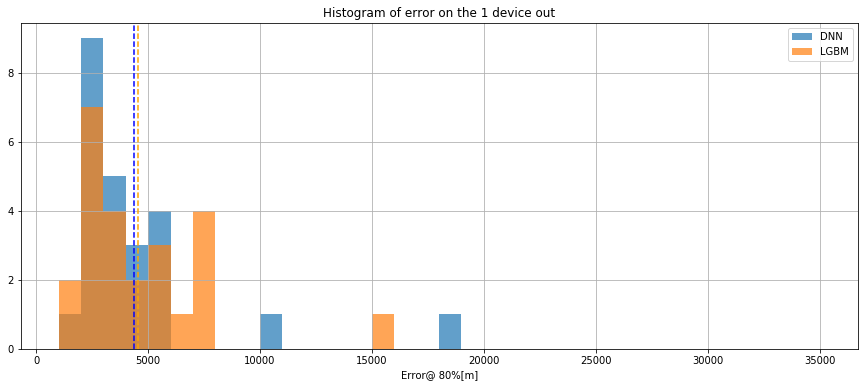

In [36]:
bins = np.arange(1, 36) * 1000

errorMeanOverDevicesDnn = np.array(errors80Dnn).mean()
errorMeanOverDevicesLgbm = np.array(errors80Lgbm).mean()

print('Mean error over device folds @ 80%%, DNN : %.1fm, LGBM : %.1fm' % \
          (errorMeanOverDevicesDnn, errorMeanOverDevicesLgbm))

fig, ax = plt.subplots(figsize=(15, 6))

ax.grid()

ax.set_title('Histogram of error on the 1 device out')

ax.set_xlabel('Error@ 80%[m]')

ax.hist(errors80Dnn,  bins=bins, alpha=0.7, label='DNN')
ax.hist(errors80Lgbm, bins=bins, alpha=0.7, label='LGBM')

ax.axvline(x=errorMeanOverDevicesDnn,  color='blue', linestyle='--')
ax.axvline(x=errorMeanOverDevicesLgbm, color='orange', linestyle='--')

ax.legend()

## Etude d'un device anormal (outlier) 

Device ID=476835 a des performances très mauvaises (erreur @ 80% > 100km).

Cette section détermine les problèmes des messages de ce device

In [37]:
outlier1Did = 476835.
outlier1Index = df_mess_train['did'] == outlier1Did
outlier1X = df_mess_train[outlier1Index]
outlier1X.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
17074,57c4a76fe541cd77a07a17be,3558,476835.0,1.0,-91.666667,1.472506e+12,39.810055,-105.010413,499108.653441,4.406676e+06,13,S
17075,57c4a76fe541cd77a07a17be,4060,476835.0,1.0,-130.000000,1.472506e+12,39.798157,-104.915073,507270.638137,4.405358e+06,13,S
17076,57c4a76fe541cd77a07a17be,8475,476835.0,1.0,-124.000000,1.472506e+12,39.811782,-105.026329,497746.413704,4.406868e+06,13,S
17086,57c4aa0612f14345918d26f0,1661,476835.0,1.0,-135.000000,1.472506e+12,39.753850,-105.018596,498408.273587,4.400438e+06,13,S
17087,57c4aa0612f14345918d26f0,1859,476835.0,1.0,-129.000000,1.472506e+12,39.704887,-105.016392,498594.756068,4.395004e+06,13,S


In [38]:
outlier1MessId = df_mess_train[outlier1Index].reset_index()['messid'].unique()
outlier1MessId.shape

(69,)

In [39]:
df_feat_rank1OutlierIndex = (df_feat['did'] == outlier1Did)
df_feat_red[df_feat_rank1OutlierIndex].head()

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,
57c4a76fe541cd77a07a17be,0,4.406676e+06,499108.653441,3.725290e-09,-5.820766e-11,-91.666667,192.003026,-1362.239737,-124.0,-1317.076119,8161.984696,-130.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0
57c4aa0612f14345918d26f0,0,4.400730e+06,498409.895472,-2.921323e+02,-1.621885e+00,-108.000000,-292.132342,-1.621885,-109.0,4117.431978,27.554722,-110.333333,4576.362967,-3566.570482,-117.333333,2683.939041,-3006.311924,-118.0
57c4aca6cf554f465a3baffd,0,4.403426e+06,494000.061431,1.507861e+02,-2.254612e+02,-112.000000,-2987.858655,4408.212156,-115.0,-2634.888301,8044.954901,-119.333333,-983.485817,5193.529330,-120.000000,4539.020166,4019.030736,-123.0
57c69d31e541cd77a0d00095,0,4.403414e+06,495403.583546,-4.034489e-06,1.366949e-06,-87.000000,1892.423922,-560.258557,-107.0,88.848316,1105.795196,-109.666667,285.668446,-3002.883958,-110.000000,2568.978638,-1574.739607,-111.0
57c69f7fcf554f465a9067a7,0,4.406162e+06,496495.278297,-9.313226e-10,-1.164153e-10,-125.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,-1000.0


In [40]:
outlier1y = ground_truth[df_feat_rank1OutlierIndex.values]
outlier1y.head()

,x,y,utm_zone,utm_letter
messid,,,,
57c4a76fe541cd77a07a17be,499943.884136,4.406363e+06,13,S
57c4aa0612f14345918d26f0,499566.265716,4.404406e+06,13,S
57c4aca6cf554f465a3baffd,499279.462179,4.405150e+06,13,S
57c69d31e541cd77a0d00095,495787.977617,4.403556e+06,13,S
57c69f7fcf554f465a9067a7,495759.856805,4.403579e+06,13,S


Utilisation du dernier estimateur LGBM

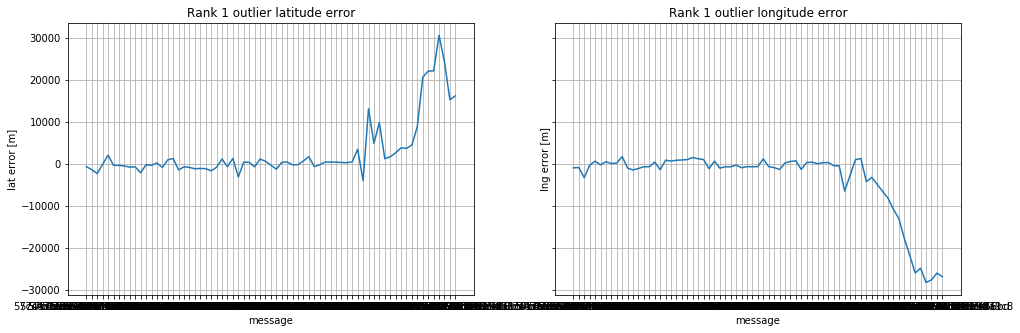

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

error_lat = model_lat.predict(df_feat_red.loc[outlier1MessId]) - outlier1y['y']

axes[0].plot(error_lat)
axes[0].set_title('Rank 1 outlier latitude error')
axes[0].set_xlabel('message')
axes[0].set_ylabel('lat error [m]')
axes[0].grid()

error_lng = model_lng.predict(df_feat_red.loc[outlier1MessId]) - outlier1y['x']

axes[1].plot(error_lng)
axes[1].set_title('Rank 1 outlier longitude error')
axes[1].set_xlabel('message')
axes[1].set_ylabel('lng error [m]')
axes[1].grid()

In [42]:
df_feat_red.loc[outlier1MessId][50:]

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs2_deltalng,bs2_rssi,bs3_deltalat,bs3_deltalng,bs3_rssi,bs4_deltalat,bs4_deltalng,bs4_rssi
messid,,,,,,,,,,,,,,,,,,
57caac10cf554f22dc98a7bc,0,4.391937e+06,504054.661777,-1.058727e-01,3.764038e-02,-117.000000,2749.218941,6501.696312,-129.0,14505.253384,-12431.216893,-129.0,4694.462638,2398.979125,-137.0,0.0,0.0,-1000.0
57cab3e6e541cd01b3916b53,0,4.365528e+06,508189.519044,2.579776e+03,-4.398068e+02,-126.000000,-19014.946037,3261.586274,-128.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf60bae541cd01b3a7c341,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-125.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf634de541cd01b3a96177,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-129.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf6b24e541cd01b3ae6cd8,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-127.333333,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf6dc5cf554f22dcbe4c71,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-130.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf705fcf554f22dcbff061,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-135.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf72ff12f1437531e332ec,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-136.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0
57cf759ee541cd01b3b5923f,0,4.045202e+06,712078.392982,2.793968e-09,0.000000e+00,-137.000000,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.000000,0.000000,-1000.0,0.0,0.0,-1000.0


Les 17 derniers messages n'ont qu'une seule BS et le device s'éloigne de la BS.

Ils sont affichés en bleu sur la carte suivante, au sud de Denver. Les BS, de tous les messages de ce device, sont en rouge.

In [43]:
m = folium.Map(
    location=[39.8, -105.0],
    zoom_start=6,
    tiles='Stamen Terrain'
)

for r in outlier1X.iterrows():
    row = r[1]
    folium.Circle(
        radius=max(5, 200+row['rssi']),
        location=[row['bs_lat'], row['bs_lng']],
        color='crimson',
        fill=False,
    ).add_to(m)

for r in outlier1y[52:].iterrows():
    row = r[1]
    lat, lng = xy_to_latlon(row[0], row[1], row[2], row[3])
    folium.Circle(
        radius=10,
        location=[lat, lng],
        color='blue',
        fill=False,
    ).add_to(m)

m

## Construction des vecteurs lat/lng de prédictions de test

Les labels ne sont pas connus.

In [44]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,bs_x,bs_y,bs_utm_zone,bs_utm_letter
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032,486028.742773,4.397654e+06,13,S
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479,494649.699245,4.403332e+06,13,S
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676,495403.583548,4.403414e+06,13,S
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032,486028.742773,4.397654e+06,13,S
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747,492400.699589,4.403700e+06,13,S


In [45]:
# build matrix for the test dataset
df_feat_test = feat_mat_const(df_mess_test, listOfBs)

# apply model
y_pred_test_lat, y_pred_test_lng = lgbmPredict(lgbmModels, df_feat_test, True)

In [47]:
test_res = pd.DataFrame(np.c_[y_pred_test_lat, y_pred_test_lng], columns = ['lat', 'lng'])
test_res = pd.concat([test_res, df_mess_test['messid']], axis=1)

test_res.to_csv('pred_pos_test_list.csv', index=False)

In [48]:
test_res.head()

,lat,lng,messid
0,39.752333,-105.090626,573be2503e952e191262c351
1,39.776430,-105.079902,573c05f83e952e1912758013
2,39.695171,-105.011792,573c05f83e952e1912758013
3,39.779801,-105.070321,573c05f83e952e1912758013
4,39.693399,-105.011592,573c05f83e952e1912758013
